In [1]:
import os
import gym
import gym_maze
import numpy as np
import random
import time
import tqdm
from matplotlib import pyplot as plt

import json

for i in tqdm.tqdm_notebook(range(1)):
    pass
for i in tqdm.notebook.tqdm(range(1)):
    pass

In [220]:

class CrossEntropyMethod():
    def __init__(self, name, state_n, action_n):
        self.name = name
        self.state_n = state_n
        self.action_n = action_n
        self.policy = np.ones((self.state_n, self.action_n)) / self.action_n
    
    def get_action(self, state):
        return int(np.random.choice(self.action_n, p=self.policy[state]))
    def get_det_action(self, state):
        return np.argmax(self.policy[state])
    
    def update_policy(self, elite_trajectories):
        pre_policy = np.zeros((self.state_n, self.action_n))
        
        # counter
        for trajectory in elite_trajectories:
            for state, action in zip(trajectory['states'], trajectory['actions']):
                pre_policy[state][action] += 1
        
        # 
        for state in range(self.state_n):
            if sum(pre_policy[state]) == 0:
                self.policy[state] = np.ones(self.action_n) / self.action_n
            else:
                self.policy[state] = pre_policy[state] / sum(pre_policy[state])
        self.save_policy()
        return None
    def laplace_update_policy(self, elite_trajectories):
        pre_policy = np.zeros((self.state_n, self.action_n))
        
        # counter
        for trajectory in elite_trajectories:
            for state, action in zip(trajectory['states'], trajectory['actions']):
                pre_policy[state][action] += 1
        
        # 
        for state in range(self.state_n):
            if sum(pre_policy[state]) == 0:
                self.policy[state] = np.ones(self.action_n) / self.action_n
            else:
                self.policy[state] = (pre_policy[state]+lambd) / (sum(pre_policy[state])+lambd*self.action_n)
        self.save_policy()
        return None
    def policy_smoothing_update(self, elite_trajectories, lambd):
        pre_policy = np.zeros((self.state_n, self.action_n))
        
        # counter
        for trajectory in elite_trajectories:
            for state, action in zip(trajectory['states'], trajectory['actions']):
                pre_policy[state][action] += 1
        
        # 
        for state in range(self.state_n):
            if sum(pre_policy[state]) == 0:
                new_policy = np.ones(self.action_n) / self.action_n
            else:
                new_policy = pre_policy[state] / sum(pre_policy[state])
            self.policy[state] = lambd*new_policy+ (1-lambd)*self.policy[state]
        self.save_policy()
        return None
    def save_policy(self):
        np.save(f'{env.spec.id}-{self.name}', self.policy)
    def load_policy(self):
        fname = f'{env.spec.id}-{self.name}.npy'
        if os.path.exists(fname):
            self.policy = np.load(fname)

In [225]:
def delivered(state):
    taxi_row, taxi_col, passenger_location, destination = env.decode(state)
    return passenger_location == destination

In [7]:
#test
env = gym.make("Taxi-v3")


In [154]:
action_n = 6
state_n = 500
trajectory_len = 200
agent2 = CrossEntropyMethod('agent2', state_n, action_n)
# agent2.policy = np.load('./Taxi-v3-laplase_100_200_160_0.9_0.99.npy')
# agent2.policy = np.load('./Taxi-v3-laplase_100_200_320_0.9_0.9.npy')
# agent2.policy = np.load('./Taxi-v3-laplase_100_200_1280_0.9_0.5.npy')
# agent2.policy = np.load('./Taxi-v3-true-laplase_100_200_1280_0.9_0.2.npy')

In [20]:

final_rewards = []
state = env.reset()
env.render()
time.sleep(1)
taxi_row, taxi_col, passenger_location, destination = env.decode(state)
print(taxi_row, taxi_col, passenger_location, destination)
test_reward = 0
for step in range(trajectory_len):
    action = agent2.get_action(state)
    state, reward, done, _ = env.step(action)
    test_reward += reward
    env.render()
    if done:
        break
    time.sleep(0.125)
taxi_row, taxi_col, passenger_location, f_destination = (env.decode(state))
print(taxi_row, taxi_col, passenger_location, destination, action)
final_rewards.append([test_reward, action, step])
#     print('Test Reward', test_reward)


3 2 1 0
0 0 0 0 5


In [226]:
def sample_policy(policy, action_n):
    ret_policy = np.zeros(policy.shape)
#     print(ret_policy)
    actions = np.arange(action_n)
    for i, p in enumerate(policy):
        idx =np.random.choice(actions, p=p)
#         print(idx)
        ret_policy[i][idx] = 1
    return ret_policy


In [224]:
policy = [
         [0.1,0.2,0.3,0.4],
         [0.4,0.2,0.3,0.1],
         [0.1,0.4,0.3,0.2]]

policy = np.array(policy)

sample_policy(policy, 4)

array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

In [227]:
def get_trajectory(env, agent, trajectory_len):
    trajectory = {
        'states':[], 
        'actions':[],
        'total_reward': 0}
    state = env.reset()
    trajectory['states'].append(state)
    for _ in range(trajectory_len):
#         action = agent.get_action(state)
        action = agent.get_det_action(state)
        trajectory['actions'].append(action)
        state, reward, done, _ = env.step(action)
        trajectory['states'].append(state)
        trajectory['total_reward'] += reward
        if done:
            break
    return trajectory

In [254]:
action_n = 6
state_n = 500
episode_n = 100
trajectory_len = 100
trajectory_n = 10
det_policy_n = 100
q_param = 0.9
lambd = 0.1

In [261]:
def get_elite_det_trajectories(det_trajectories,
                                det_policies_mean_total_reward,
                                q_param):
#     total_rewards = [trajectory['total_reward'] for trajectory in det_policies_mean_total_reward]
    quantile = np.quantile(det_policies_mean_total_reward, q=q_param)
    ret_policy = []
    cnt = 0
    for mtr, traj in zip(det_policies_mean_total_reward, det_trajectories):
        if mtr > quantile:
            cnt+=1 
            ret_policy += traj
#     print(cnt)
    return ret_policy


In [262]:
def get_tasks(episodes_n, trajectories_len, trajectories_n, det_policies_n, q_params, lambdas):
    tasks = []
    for episode_n in episodes_n:
        for trajectory_len in trajectories_len:
            for trajectory_n in trajectories_n:
                for det_policy_n in det_policies_n:
                    for q_param in q_params:
                        for lambd in lambdas:
                            tasks.append((episode_n, trajectory_len, trajectory_n, det_policy_n, q_param, lambd))
    return tasks

In [263]:
def experiment(episode_n, trajectory_len, trajectory_n, det_policy_n, q_param, lambd, position):
    exp = {
        'det_policy_n': det_policy_n,
        'episode_n':episode_n,
        'trajectory_len':trajectory_len,
        'trajectory_n':trajectory_n,
        'q_param':q_param,
        'lamd':lambd,
        'episode_data':[]
    }
    name = f'det_CEM_{episode_n}_{trajectory_len}_{trajectory_n}_{q_param}_{lambd}_{det_policy_n}'

    agent = CrossEntropyMethod(name, state_n, action_n)
    env = gym.make("Taxi-v3")
    episode_data = []
    for _ in tqdm.notebook.tqdm(range(episode_n), desc='Episodes', position=0):

        saved_policy = agent.policy
    #     det_policies = []
        det_trajectories =[]
        det_policies_mean_total_reward = []

        for _ in range(det_policy_n):
            det_policy = sample_policy(saved_policy, action_n)
    #         det_policies.append(det_policy)

            agent.policy = det_policy
            trajectories = [get_trajectory(env, agent, trajectory_len) for _ in range(trajectory_n)]
            det_trajectories.append(trajectories)

            mean_total_reward = np.mean([trajectory['total_reward'] for trajectory in trajectories])
            det_policies_mean_total_reward.append(mean_total_reward)

        elite_trajectories = get_elite_det_trajectories(det_trajectories,
                                                        det_policies_mean_total_reward,
                                                        q_param)
#         print(np.mean(det_policies_mean_total_reward), det_policies_mean_total_reward, len(elite_trajectories))
        episode_data.append((det_policies_mean_total_reward, len(elite_trajectories)))
        if len(elite_trajectories) > 0:
            agent.update_policy(elite_trajectories)
        else:
            agent.policy = saved_policy
        #         print(mean_total_reward, len(elite_trajectories))
        exp['episode_data'] = episode_data
        json.dump(exp, open(f'./experiments/{agent.name}.json','w'))

In [269]:
episodes_n = [100]
trajectories_len = [20]
trajectories_n =  [20]
det_policies_n = [200]
q_params = [0.5]
# q_params = [0.1, 0.5, 0.9]
lambdas = [0.1]

tasks = get_tasks(episodes_n, trajectories_len, trajectories_n, det_policies_n, q_params, lambdas)

for task in tqdm.notebook.tqdm(tasks, desc='Tasks'):
    print(task)
    experiment(*task, position=3)

(100, 20, 20, 200, 0.5, 0.1)


In [272]:
episodes_n = [200]
trajectories_len = [35]
trajectories_n =  [20]
det_policies_n = [100]
q_params = [0.5]
# q_params = [0.1, 0.5, 0.9]
lambdas = [0.1]

tasks = get_tasks(episodes_n, trajectories_len, trajectories_n, det_policies_n, q_params, lambdas)

for task in tqdm.notebook.tqdm(tasks, desc='Tasks'):
    print(task)
    experiment(*task, position=3)

(200, 35, 20, 100, 0.5, 0.1)


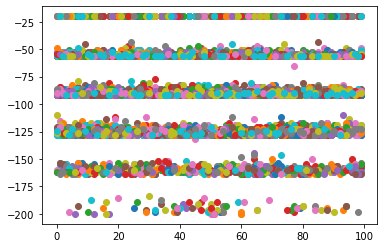

In [253]:
for ed in exp['episode_data']:
    plt.scatter(range(len(ed[0])), ed[0])

In [200]:
import json

In [163]:
# TEST
env = gym.make("Taxi-v3")

final_rewards = []
for _ in tqdm.tqdm(range(1000)):
    state = env.reset()
    taxi_row, taxi_col, passenger_location, destination = env.decode(state)
    test_reward = 0
    for step in range(trajectory_len):
        action = agent2.get_action(state)
        state, reward, done, _ = env.step(action)
        test_reward += reward
        if done:
            print(st)
            break
    taxi_row, taxi_col, passenger_location, f_destination = (env.decode(state))
    final_rewards.append([test_reward, step, delivered(state)])

final_rewards = np.array(final_rewards)

  2%|▏         | 17/1000 [00:03<03:28,  4.71it/s]


KeyboardInterrupt: 

In [92]:
max(final_rewards[::,2])

1

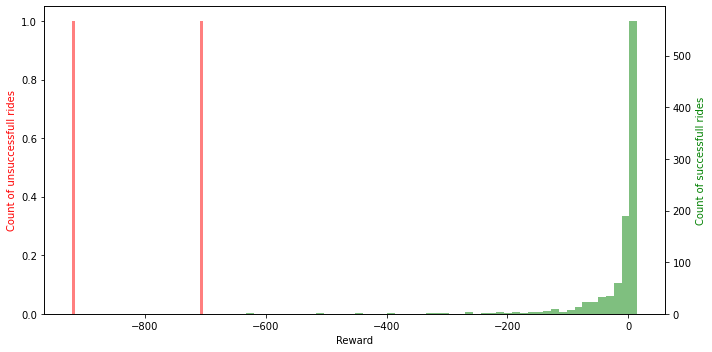

In [90]:
fig, ax = plt.subplots(figsize = (10, 5))
ax2 = ax.twinx()
ax.hist(final_rewards[final_rewards[::,2]==0][::,0], bins=50, alpha=0.5, color='r')
ax2.hist(final_rewards[final_rewards[::,2]==1][::,0], bins=50, alpha=0.5, color='g')
ax.set_xlabel('Reward')
ax.set_ylabel('Count of unsuccessfull rides', color = 'r')
ax2.set_ylabel('Count of successfull rides', color = 'g')
plt.tight_layout()
plt.show()

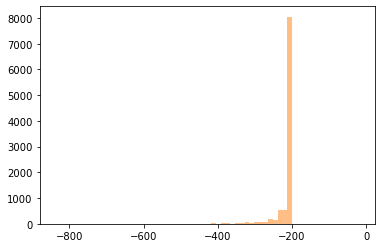

In [49]:
plt.hist(final_rewards[final_rewards[::,2]==0][::,0], bins=50, alpha=0.5)
plt.show()